In [1]:
%autosave 60

Autosaving every 60 seconds


In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import collections #for frequeny counting
import findspark
findspark.init("/home/amol/software/spark2/")

import pyspark
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import lit #create columns of *literal* value
from pyspark.sql.functions import col #Returns columns given on column name
from pyspark.ml.feature import StringIndexer #label encoding
from pyspark.ml import Pipeline

sc = pyspark.SparkContext(appName="helloworld")

In [2]:
import matplotlib.pyplot as plt
import warnings #for filtering warnings

#constants
%matplotlib inline
sns.set_style("dark")
#to ignore warnings in output
warnings.filterwarnings('ignore')
#global information settings
sigLev = 2 #three significant digits
percentMul = 100 #for percentage multiplication
figWidth = figHeight = 8

### Spark Session

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
trainDF = spark.read.csv("train.csv", header="true")
testDF = spark.read.csv("test.csv", header="true")

In [5]:
trainDF.printSchema()

root
 |-- id: string (nullable = true)
 |-- cat1: string (nullable = true)
 |-- cat2: string (nullable = true)
 |-- cat3: string (nullable = true)
 |-- cat4: string (nullable = true)
 |-- cat5: string (nullable = true)
 |-- cat6: string (nullable = true)
 |-- cat7: string (nullable = true)
 |-- cat8: string (nullable = true)
 |-- cat9: string (nullable = true)
 |-- cat10: string (nullable = true)
 |-- cat11: string (nullable = true)
 |-- cat12: string (nullable = true)
 |-- cat13: string (nullable = true)
 |-- cat14: string (nullable = true)
 |-- cat15: string (nullable = true)
 |-- cat16: string (nullable = true)
 |-- cat17: string (nullable = true)
 |-- cat18: string (nullable = true)
 |-- cat19: string (nullable = true)
 |-- cat20: string (nullable = true)
 |-- cat21: string (nullable = true)
 |-- cat22: string (nullable = true)
 |-- cat23: string (nullable = true)
 |-- cat24: string (nullable = true)
 |-- cat25: string (nullable = true)
 |-- cat26: string (nullable = true)
 |-- cat

In [6]:
trainDF.describe("loss").show()

+-------+------------------+
|summary|              loss|
+-------+------------------+
|  count|            188318|
|   mean|3037.3376856699815|
| stddev| 2904.086186390404|
|    min|              0.67|
|    max|           9998.96|
+-------+------------------+



In [6]:
trainDF.createOrReplaceTempView("train")

In [15]:
trainDF.columns

['id',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18',
 'cat19',
 'cat20',
 'cat21',
 'cat22',
 'cat23',
 'cat24',
 'cat25',
 'cat26',
 'cat27',
 'cat28',
 'cat29',
 'cat30',
 'cat31',
 'cat32',
 'cat33',
 'cat34',
 'cat35',
 'cat36',
 'cat37',
 'cat38',
 'cat39',
 'cat40',
 'cat41',
 'cat42',
 'cat43',
 'cat44',
 'cat45',
 'cat46',
 'cat47',
 'cat48',
 'cat49',
 'cat50',
 'cat51',
 'cat52',
 'cat53',
 'cat54',
 'cat55',
 'cat56',
 'cat57',
 'cat58',
 'cat59',
 'cat60',
 'cat61',
 'cat62',
 'cat63',
 'cat64',
 'cat65',
 'cat66',
 'cat67',
 'cat68',
 'cat69',
 'cat70',
 'cat71',
 'cat72',
 'cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 

In [22]:
trainDF.columns[117:132]

['cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'loss']

In [6]:
# Let's define function
def to_anytype(df, colnames, typename):
    for colname in colnames:
        df = df.withColumn("tmp", df[colname].cast(typename)) \
        .drop(colname) \
        .withColumnRenamed("tmp", colname)
    return(df)

In [7]:
intCols = ['id']

floatCols = ['cont1','cont2','cont3','cont4','cont5','cont6','cont7','cont8','cont9','cont10','cont11',
             'cont12','cont13','cont14','loss']

stringCols = ['cat1','cat2','cat3','cat4','cat5','cat6','cat7','cat8','cat9','cat10','cat11','cat12',
              'cat13','cat14','cat15','cat16','cat17','cat18','cat19','cat20','cat21','cat22','cat23',
              'cat24','cat25','cat26','cat27','cat28','cat29','cat30','cat31','cat32','cat33','cat34',
              'cat35','cat36','cat37','cat38','cat39','cat40','cat41','cat42','cat43','cat44','cat45',
              'cat46','cat47','cat48','cat49','cat50','cat51','cat52','cat53','cat54','cat55','cat56',
              'cat57','cat58','cat59','cat60','cat61','cat62','cat63','cat64','cat65','cat66','cat67',
              'cat68','cat69','cat70','cat71','cat72','cat73','cat74','cat75','cat76','cat77','cat78',
              'cat79','cat80','cat81','cat82','cat83','cat84','cat85','cat86','cat87','cat88','cat89',
              'cat90','cat91','cat92','cat93','cat94','cat95','cat96','cat97','cat98','cat99','cat100',
              'cat101','cat102','cat103','cat104','cat105','cat106','cat107','cat108','cat109','cat110',
              'cat111','cat112','cat113','cat114','cat115','cat116']
trainDF = to_anytype(trainDF, intCols, "integer")
trainDF = to_anytype(trainDF, floatCols, "float")
trainDF = to_anytype(trainDF, stringCols, "string")

## Univariate analysis

In [8]:
loss_hist = spark.sql(
    "SELECT loss, \
            count(*) AS count \
    FROM train \
    GROUP BY loss \
    ORDER BY loss")
loss_hist.show(n=loss_hist.count())

+---------+-----+
|     loss|count|
+---------+-----+
|     0.67|    1|
|       10|    1|
|      100|    1|
|     1000|    8|
|  1000.01|    1|
|  1000.02|    1|
|  1000.05|    2|
|  1000.06|    3|
|  1000.09|    1|
|  1000.11|    1|
|  1000.14|    2|
|  1000.15|    2|
|  1000.16|    1|
|  1000.19|    2|
|  1000.21|    2|
|  1000.25|    2|
|  1000.26|    2|
|  1000.29|    1|
|  1000.31|    2|
|  1000.33|    2|
|  1000.34|    1|
|  1000.35|    1|
|  1000.37|    1|
|  1000.39|    1|
|  1000.45|    2|
|  1000.46|    2|
|  1000.47|    1|
|  1000.48|    1|
|  1000.49|    1|
|  1000.54|    1|
|  1000.56|    1|
|  1000.57|    2|
|  1000.58|    1|
|  1000.62|    1|
|  1000.63|    1|
|  1000.64|    3|
|  1000.65|    1|
|  1000.67|    1|
|  1000.69|    3|
|   1000.7|    1|
|  1000.74|    1|
|  1000.75|    2|
|  1000.78|    2|
|   1000.8|    1|
|  1000.81|    1|
|  1000.88|    1|
|  1000.89|    1|
|   1000.9|    2|
|  1000.91|    2|
|  1000.92|    1|
|  1000.96|    1|
|  1000.97|    1|
|  1000.99

In [9]:
loss_hist = spark.sql(
    "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(loss/10000.00)*10000 as bucket_floor, \
            floor(loss/10000.00)*10000 + 10000 as bucket_ceiling \
        FROM train \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1")

loss_hist.show(n=loss_hist.count())

+------------+----------------+------+
|bucket_floor|     bucket_name| count|
+------------+----------------+------+
|           0|      0 to 10000|182438|
|       10000|  10000 to 20000|  5442|
|       20000|  20000 to 30000|   375|
|       30000|  30000 to 40000|    40|
|       40000|  40000 to 50000|    12|
|       50000|  50000 to 60000|     5|
|       60000|  60000 to 70000|     2|
|       70000|  70000 to 80000|     1|
|       80000|  80000 to 90000|     1|
|      100000|100000 to 110000|     1|
|      120000|120000 to 130000|     1|
+------------+----------------+------+



In [11]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

loss = get_column(loss_hist, "bucket_name")
count_loss = get_column(loss_hist, "count")

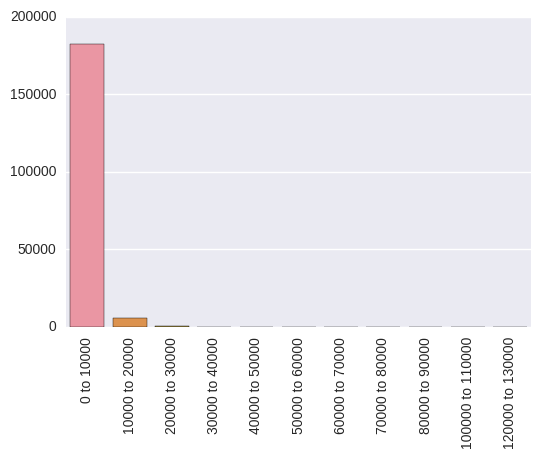

In [12]:
%matplotlib inline

barplt = sns.barplot(loss, count_loss)
for item in barplt.get_xticklabels():
    item.set_rotation(90)

## Histogram function

In [8]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

def histplot(dfname, colname, binsize):
    binsize = str(binsize)
    dfname.createOrReplaceTempView("tmpDF")
    hist_query = "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(" + colname + "/" + binsize + ")*" + binsize + " as bucket_floor, \
            floor(" + colname + "/" + binsize + ")*" + binsize + " + " + binsize + " as bucket_ceiling \
        FROM tmpDF \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1"
    hist_data = spark.sql(hist_query)
    xvar = get_column(hist_data, "bucket_name")
    count = get_column(hist_data, "count")
    barplt = sns.barplot(xvar, count)
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

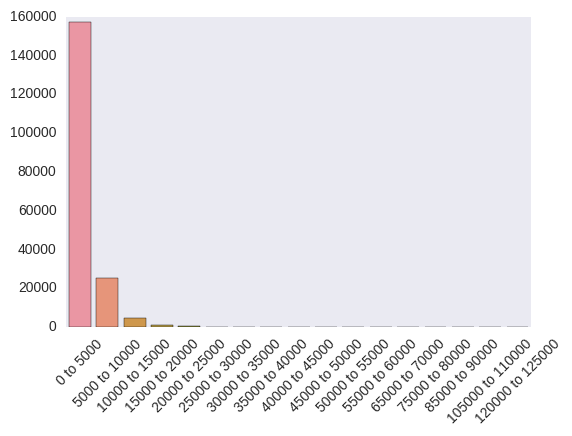

In [11]:
histplot(trainDF, "loss", 5000)

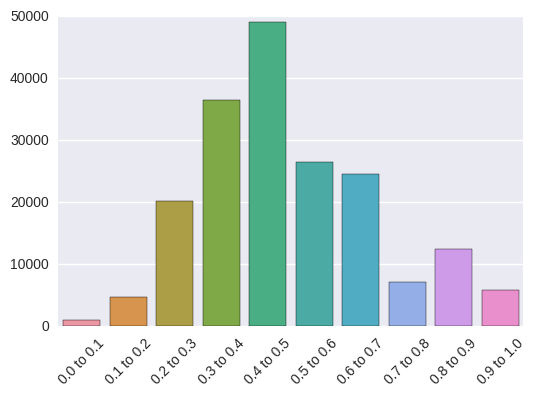

In [35]:
histplot(trainDF, "cont1", .1)

In [ ]:
histplot(trainDF, "cont2", .1)

In [ ]:
histplot(trainDF, "cont3", .1)

In [ ]:
histplot(trainDF, "cont4", .1)

In [ ]:
histplot(trainDF, "cont5",.1)

In [ ]:
histplot(trainDF, "cont6", .1)

In [ ]:
histplot(trainDF, "cont7", .1)

In [ ]:
histplot(trainDF, "cont8", .1)

In [ ]:
histplot(trainDF, "cont9", .1)

In [ ]:
histplot(trainDF, "cont10", .1)

In [ ]:
histplot(trainDF, "cont11", .1)

In [ ]:
histplot(trainDF, "cont12", .1)

In [ ]:
histplot(trainDF, "cont13", .1)

In [ ]:
histplot(trainDF, "cont14", .1)

### Cat hist


In [9]:
def histplot_s(df, colname):
    xvar = get_column(df, colname)
    counter = collections.Counter(xvar)
    barplt = sns.barplot(list(counter.keys()), list(counter.values()))
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

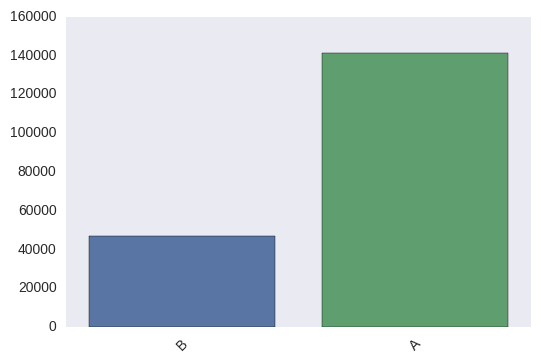

In [13]:
histplot_s(trainDF, "cat1")

In [55]:
cat_col = spark.sql("SELECT cat1, cat2, cat3, cat4, cat5, cat6, cat7, cat8, cat9, cat10,\
                    cat11, cat12, cat13, cat14, cat15, cat16, cat17, cat18, cat19, cat20, cat21, cat22,\
                    cat23, cat24, cat25, cat26, cat27, cat28, cat29, cat30, cat31, cat32, cat33, cat34,\
                    cat35, cat36, cat37, cat38, cat39, cat40, cat41, cat42, cat43, cat44, cat45, cat46,\
                    cat47, cat48, cat49, cat50, cat51, cat52, cat53, cat54, cat55, cat56, cat57, cat58,\
                    cat59, cat60, cat61, cat62, cat63, cat64, cat65, cat66, cat67, cat68, cat69, cat70,\
                    cat71, cat72, cat73, cat74, cat75, cat76, cat77, cat78, cat79, cat80, cat81, cat82,\
                    cat83, cat84, cat85, cat86, cat87, cat88, cat89, cat90, cat91, cat92, cat93, cat94, \
                    cat95, cat96, cat97, cat98, cat99, cat100, cat101, cat102, cat103, cat104, cat105,\
                    cat106, cat107, cat108, cat109, cat110, cat111, cat112, cat113, cat114, cat115, \
                    cat116 FROM train")

cat_col.show(1)

+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|cat1|cat2|cat3|cat4|cat5|cat6|cat7|cat8|cat9|cat10|cat11|cat12|cat13|cat14|cat15|cat16|cat17|cat18|cat19|cat20|cat21|cat22|cat23|cat24|cat25|cat26|cat27|cat28|cat29|cat30|cat31|cat32|cat33|cat34|cat35|cat36|cat37|cat38|cat39|cat40|cat41|cat42|cat43|cat44|cat45|cat46|cat47|cat48|cat49|cat50|ca

In [56]:
cont_col = spark.sql("SELECT cont1,cont2,cont3,cont4,cont5,cont6,cont7,\
                    cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss\
                    FROM train")

cont_col.show(1)

+------+--------+--------+--------+--------+--------+-------+------+-------+------+--------+--------+--------+--------+-------+
| cont1|   cont2|   cont3|   cont4|   cont5|   cont6|  cont7| cont8|  cont9|cont10|  cont11|  cont12|  cont13|  cont14|   loss|
+------+--------+--------+--------+--------+--------+-------+------+-------+------+--------+--------+--------+--------+-------+
|0.7263|0.245921|0.187583|0.789639|0.310061|0.718367|0.33506|0.3026|0.67135|0.8351|0.569745|0.594646|0.822493|0.714843|2213.18|
+------+--------+--------+--------+--------+--------+-------+------+-------+------+--------+--------+--------+--------+-------+
only showing top 1 row



In [78]:
cont_col.corr('cont1', 'cont2')

-0.08518029261705777

In [80]:
from pyspark.mllib.stat import Statistics

In [108]:
features = cont_col.rdd.map(lambda row: row[0:])
type(features)

pyspark.rdd.PipelinedRDD

In [83]:
corr_mat=Statistics.corr(features, method="pearson")

In [84]:
corr_mat

array([[ 1.        , -0.08518029, -0.44543148,  0.36754923, -0.02522994,
         0.75831532,  0.36738446,  0.36116252,  0.9299117 ,  0.80855087,
         0.59608979,  0.61422545,  0.53484952,  0.05668837, -0.01023694],
       [-0.08518029,  1.        ,  0.45586092,  0.03869311,  0.19142746,
         0.01586389,  0.04818716,  0.13746777, -0.03272913,  0.0635264 ,
         0.11682355,  0.10625016,  0.02333466, -0.04558425,  0.14152796],
       [-0.44543148,  0.45586092,  1.        , -0.3416332 ,  0.08941736,
        -0.34927774,  0.097516  , -0.18543231, -0.41705405, -0.32556204,
         0.02527092,  0.00611065, -0.41820257, -0.03959232,  0.11105331],
       [ 0.36754923,  0.03869311, -0.3416332 ,  1.        ,  0.1637477 ,
         0.2209323 , -0.11506356,  0.5287403 ,  0.32896065,  0.28329423,
         0.12092661,  0.13045304,  0.17934193,  0.01744543, -0.03583081],
       [-0.02522994,  0.19142746,  0.08941736,  0.1637477 ,  1.        ,
        -0.14981039, -0.24934373,  0.0090147 , 

## pandas

In [5]:
train_1 = pd.read_csv("train.csv")
type(train_1)

pandas.core.frame.DataFrame

In [15]:
train_1.describe()

id          cont1          cont2          cont3  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean   294135.982561       0.493861       0.507188       0.498918   
std    169336.084867       0.187640       0.207202       0.202105   
min         1.000000       0.000016       0.001149       0.002634   
25%    147748.250000       0.346090       0.358319       0.336963   
50%    294539.500000       0.475784       0.555782       0.527991   
75%    440680.500000       0.623912       0.681761       0.634224   
max    587633.000000       0.984975       0.862654       0.944251   

               cont4          cont5          cont6          cont7  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.491812       0.487428       0.490945       0.484970   
std         0.211292       0.209027       0.205273       0.178450   
min         0.176921       0.281143       0.012683       0.069503   
25%         0.327354       0.281143       0.336105       0.350175   
50%         0.452887       0.422268       0.440945       0.438285   
75%         0.652072       0.643315       0.655021       0.591045   
max         0.954297       0.983674       0.997162       1.000000   

               cont8          cont9         cont10         cont11  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.486437       0.485506       0.498066       0.493511   
std         0.199370       0.181660       0.185877       0.209737   
min         0.236880       0.000080       0.000000       0.035321   
25%         0.312800       0.358970       0.364580       0.310961   
50%         0.441060       0.441450       0.461190       0.457203   
75%         0.623580       0.566820       0.614590       0.678924   
max         0.980200       0.995400       0.994980       0.998742   

              cont12         cont13         cont14           loss  
count  188318.000000  188318.000000  188318.000000  188318.000000  
mean        0.493150       0.493138       0.495717    3037.337686  
std         0.209427       0.212777       0.222488    2904.086186  
min         0.036232       0.000228       0.179722       0.670000  
25%         0.311661       0.315758       0.294610    1204.460000  
50%         0.462286       0.363547       0.407403    2115.570000  
75%         0.675759       0.689974       0.724623    3864.045000  
max         0.998484       0.988494       0.844848  121012.250000

In [6]:
contFeaturelist = []
for colName, x in train_1.iloc[1,:].iteritems():
    if(not str(x).isalpha()):
        contFeaturelist.append(colName)
        
print (contFeaturelist)

['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


In [7]:
contFeaturelist.remove('id')

In [8]:
corr_matrix = train_1[contFeaturelist].corr()

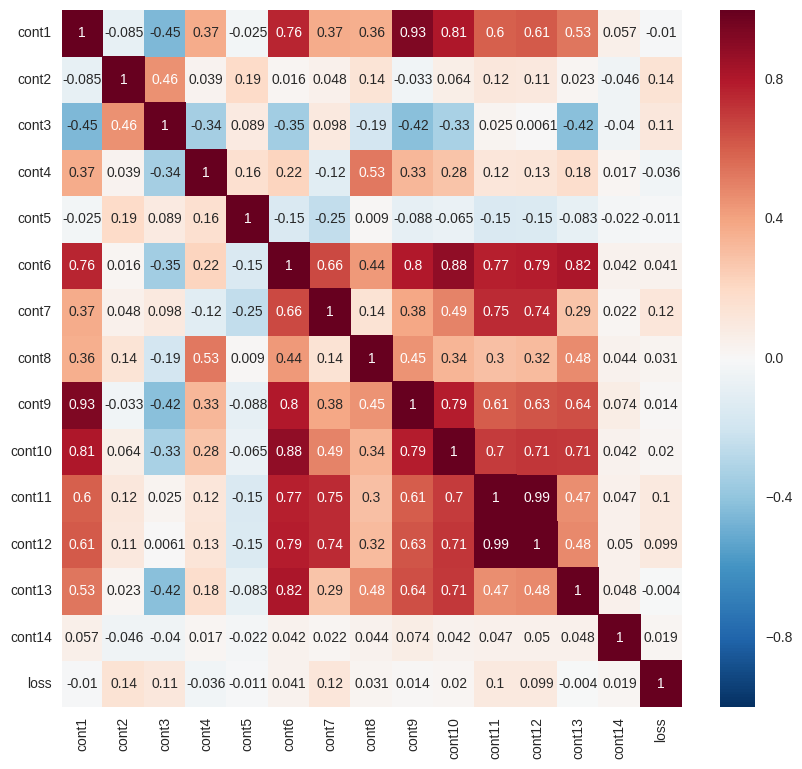

In [9]:
plt.subplots(figsize=(10,9))
corr_plt=sns.heatmap(corr_matrix, annot=True,
                    xticklabels=corr_matrix.columns.values,
                    yticklabels=corr_matrix.columns.values,)

corr_plt = sns.heatmap(corr_matrix,mask = corr_matrix < 1, cbar=False)

for item in corr_plt.get_xticklabels():
    item.set_rotation(90)
for item in corr_plt.get_yticklabels():
    item.set_rotation(360)

## Boxplot

In [211]:
contFeaturelist.remove("loss")

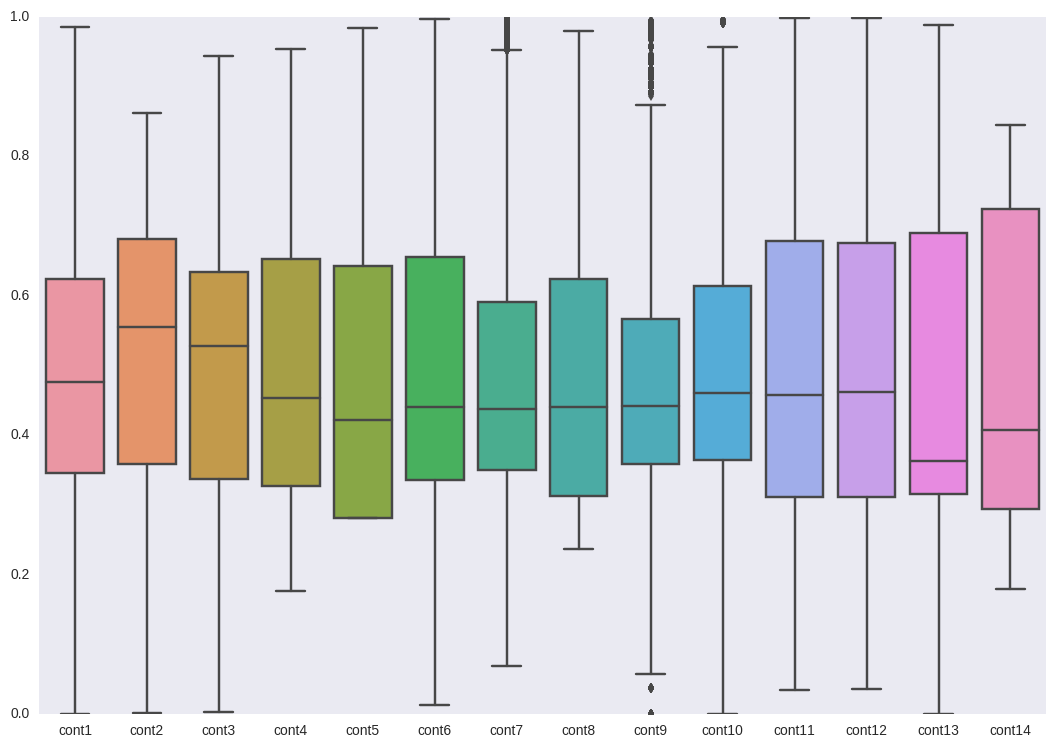

In [212]:
plt.figure(figsize=(13,9))
sns.boxplot(train_1[contFeaturelist])

## categorical variable

In [20]:
categoricalColumns = [col for col in train_1.columns if "cat" in col]

In [21]:
len(categoricalColumns)

116

In [22]:
#get num unique for each
categoricalTrainFrame = train_1[categoricalColumns]
uniqueVec = categoricalTrainFrame.apply(lambda x : x.nunique(),axis = 0) #find levels in col
nuniqueMode = uniqueVec.mode() #mode of levels


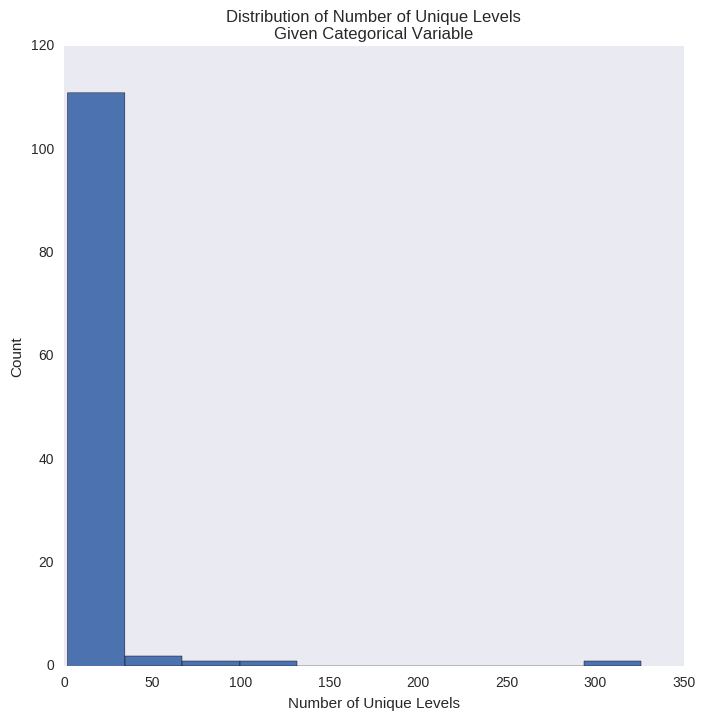

In [191]:
#then plot the distribution of number of unique levels
categoricalUniqueFigure = plt.figure(figsize = (figWidth,figHeight))
categoricalNUniqueHist = plt.hist(uniqueVec)
plt.xlabel("Number of Unique Levels")
plt.ylabel("Count")
plt.title("Distribution of Number of Unique Levels\nGiven Categorical Variable")


In [192]:

#make mapper functions
def integerizeCol(catColumn):
    #helper for integerizing a categorical column
    levels = catColumn.unique()
    counter = 0
    mapDict = {} #will add to this
    for lev in levels:
        mapDict[lev] = counter
        counter += 1
    #then integerize the column
    intCol = catColumn.map(mapDict)
    return intCol

def propMode(catColumn):
    #helper that finds the proportion of a given column is the mode
    #integerize it
    intCatColumn = integerizeCol(catColumn)
    #then get the mode
    modeOfCategory = int(intCatColumn.mode())
    #then get proportion
    numMode = intCatColumn[intCatColumn == modeOfCategory].shape[0]
    propMode = float(numMode) / intCatColumn.shape[0]
    return propMode
#then apply over categorical columns
propModeVec = categoricalTrainFrame.apply(propMode,axis = 0)

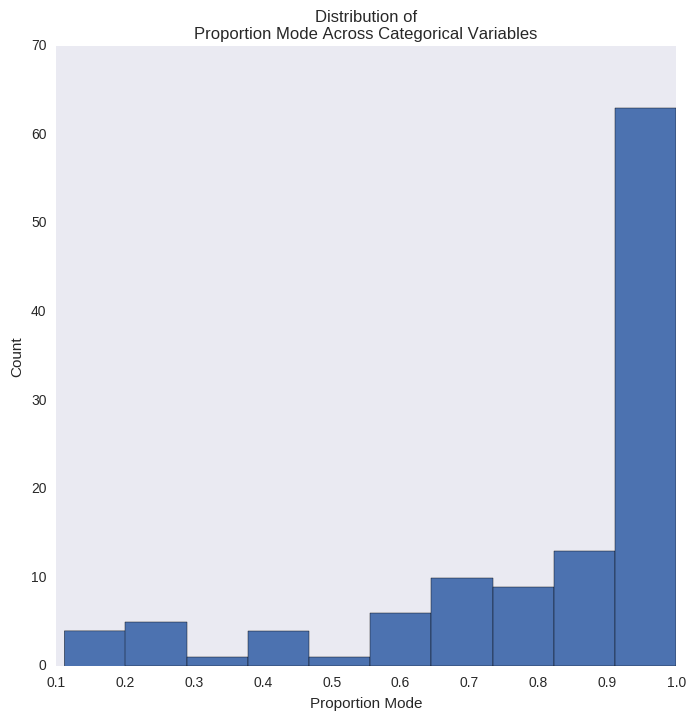

In [193]:
#then plot
givenFigure = plt.figure(figsize = (figWidth,figHeight))
plt.hist(propModeVec)
plt.xlabel("Proportion Mode")
plt.ylabel("Count")
plt.title("Distribution of\nProportion Mode Across Categorical Variables")

In [195]:
categoricalCutoff = 100 #won't consider categorical variables with fewer than
#this amount of features
propModeBelowCutoff = (
    propModeVec[(1 - propModeVec) * train_1.shape[0] < categoricalCutoff])
catToRemove = list(propModeBelowCutoff.index)
categoricalColumns = [catCol for catCol in categoricalColumns if
                        catCol not in catToRemove]

## Mssing

In [20]:
numVars = ['cont1','cont2','cont3','cont4','cont5','cont6','cont7','cont8','cont9','cont10',
           'cont11','cont12','cont13','cont14','loss']
stringVars = ['cat1','cat2','cat3','cat4','cat5','cat6','cat7','cat8','cat9','cat10','cat11','cat12',
              'cat13','cat14','cat15','cat16','cat17','cat18','cat19','cat20','cat21','cat22','cat23',
              'cat24','cat25','cat26','cat27','cat28','cat29','cat30','cat31','cat32','cat33','cat34',
              'cat35','cat36','cat37','cat38','cat39','cat40','cat41','cat42','cat43','cat44','cat45',
              'cat46','cat47','cat48','cat49','cat50','cat51','cat52','cat53','cat54','cat55','cat56',
              'cat57','cat58','cat59','cat60','cat61','cat62','cat63','cat64','cat65','cat66','cat67',
              'cat68','cat69','cat70','cat71','cat72','cat73','cat74','cat75','cat76','cat77','cat78',
              'cat79','cat80','cat81','cat82','cat83','cat84','cat85','cat86','cat87','cat88','cat89',
              'cat90','cat91','cat92','cat93','cat94','cat95','cat96','cat97','cat98','cat99','cat100',
              'cat101','cat102','cat103','cat104','cat105','cat106','cat107','cat108','cat109','cat110',
              'cat111','cat112','cat113','cat114','cat115','cat116']

In [23]:
def countNull(df,var):
    return df.where(df[var].isNull()).count()

def countEmptyString(df,var):
    return df[df[var].isin("")].count()

def countZero(df,var):
    return df[df[var].isin(0)].count()

In [182]:
missing = {var: countNull(trainDF,var) for var in trainDF.columns}
missing

KeyboardInterrupt: 

In [ ]:
missing = {var: countEmptyString(df, var) for var in df.columns}
missing

In [ ]:
missing = {var: countZero(df, var) for var in df.columns}
missing

### Categorical Variable treatment

In [10]:
## index cat1 variable
si = StringIndexer(inputCol = 'cat1', outputCol = 'cat1_indexed')
trainDF_indexed = si.fit(trainDF).transform(trainDF).drop('cat1').withColumnRenamed('cat1_indexed','cat1')

In [11]:
trainDF_indexed.describe('cat1').show()

+-------+-------------------+
|summary|               cat1|
+-------+-------------------+
|  count|             188318|
|   mean|0.24834588302764474|
| stddev| 0.4320546223176699|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [12]:
# make use of pipeline to index all categorical variables
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si

In [13]:
catVars = ['cat1','cat2','cat3','cat4','cat5','cat6','cat7','cat8','cat9','cat10','cat11','cat12',
           'cat13','cat14','cat15','cat16','cat17','cat18','cat19','cat20','cat21','cat22','cat23',
           'cat24','cat25','cat26','cat27','cat28','cat29','cat30','cat31','cat32','cat33','cat34',
           'cat35','cat36','cat37','cat38','cat39','cat40','cat41','cat42','cat43','cat44','cat45',
           'cat46','cat47','cat48','cat49','cat50','cat51','cat52','cat53','cat54','cat55','cat56',
           'cat57','cat58','cat59','cat60','cat61','cat62','cat63','cat64','cat65','cat66','cat67',
           'cat68','cat69','cat70','cat71','cat72','cat73','cat74','cat75','cat76','cat77','cat78',
           'cat79','cat80','cat81','cat82','cat83','cat84','cat85','cat86','cat87','cat88','cat89',
           'cat90','cat91','cat92','cat93','cat94','cat95','cat96','cat97','cat98','cat99','cat100',
           'cat101','cat102','cat103','cat104','cat105','cat106','cat107','cat108','cat109','cat110',
           'cat111','cat112','cat113','cat114','cat115','cat116']

In [14]:
indexers = [indexer(trainDF, col) for col in catVars]

In [15]:
pipeline = Pipeline(stages = indexers)
trainDF_indexed = pipeline.fit(trainDF).transform(trainDF)

In [16]:
trainDF_indexed.select('cat110','cat110_indexed').show(3)

+------+--------------+
|cat110|cat110_indexed|
+------+--------------+
|    BC|           7.0|
|    CQ|           9.0|
|    DK|          18.0|
+------+--------------+
only showing top 3 rows



In [54]:
trainDF.show(1)

+---+------+--------+--------+--------+--------+--------+-------+------+-------+------+--------+--------+--------+--------+-------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
| id| cont1|   cont2|   cont3|   cont4|   cont5|   cont6|  cont7| cont8|  cont9|cont10|  cont11|  cont12|  cont13|  cont14|   loss|cat1|cat2|cat3|cat4|cat5|cat6|cat

### Data format translation

In [17]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

In [18]:
catVarsIndexed = [i + '_indexed' for i in catVars]
catVarsIndexed

['cat1_indexed',
 'cat2_indexed',
 'cat3_indexed',
 'cat4_indexed',
 'cat5_indexed',
 'cat6_indexed',
 'cat7_indexed',
 'cat8_indexed',
 'cat9_indexed',
 'cat10_indexed',
 'cat11_indexed',
 'cat12_indexed',
 'cat13_indexed',
 'cat14_indexed',
 'cat15_indexed',
 'cat16_indexed',
 'cat17_indexed',
 'cat18_indexed',
 'cat19_indexed',
 'cat20_indexed',
 'cat21_indexed',
 'cat22_indexed',
 'cat23_indexed',
 'cat24_indexed',
 'cat25_indexed',
 'cat26_indexed',
 'cat27_indexed',
 'cat28_indexed',
 'cat29_indexed',
 'cat30_indexed',
 'cat31_indexed',
 'cat32_indexed',
 'cat33_indexed',
 'cat34_indexed',
 'cat35_indexed',
 'cat36_indexed',
 'cat37_indexed',
 'cat38_indexed',
 'cat39_indexed',
 'cat40_indexed',
 'cat41_indexed',
 'cat42_indexed',
 'cat43_indexed',
 'cat44_indexed',
 'cat45_indexed',
 'cat46_indexed',
 'cat47_indexed',
 'cat48_indexed',
 'cat49_indexed',
 'cat50_indexed',
 'cat51_indexed',
 'cat52_indexed',
 'cat53_indexed',
 'cat54_indexed',
 'cat55_indexed',
 'cat56_indexed',
 

In [22]:
featuresCol = numVars + catVarsIndexed
featuresCol

['cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'loss',
 'cat1_indexed',
 'cat2_indexed',
 'cat3_indexed',
 'cat4_indexed',
 'cat5_indexed',
 'cat6_indexed',
 'cat7_indexed',
 'cat8_indexed',
 'cat9_indexed',
 'cat10_indexed',
 'cat11_indexed',
 'cat12_indexed',
 'cat13_indexed',
 'cat14_indexed',
 'cat15_indexed',
 'cat16_indexed',
 'cat17_indexed',
 'cat18_indexed',
 'cat19_indexed',
 'cat20_indexed',
 'cat21_indexed',
 'cat22_indexed',
 'cat23_indexed',
 'cat24_indexed',
 'cat25_indexed',
 'cat26_indexed',
 'cat27_indexed',
 'cat28_indexed',
 'cat29_indexed',
 'cat30_indexed',
 'cat31_indexed',
 'cat32_indexed',
 'cat33_indexed',
 'cat34_indexed',
 'cat35_indexed',
 'cat36_indexed',
 'cat37_indexed',
 'cat38_indexed',
 'cat39_indexed',
 'cat40_indexed',
 'cat41_indexed',
 'cat42_indexed',
 'cat43_indexed',
 'cat44_indexed',
 'cat45_indexed',
 'cat46_indexed',
 'cat47_indexed',
 'cat48_i

In [24]:
featuresCol.remove('loss')
featuresCol

['cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'cat1_indexed',
 'cat2_indexed',
 'cat3_indexed',
 'cat4_indexed',
 'cat5_indexed',
 'cat6_indexed',
 'cat7_indexed',
 'cat8_indexed',
 'cat9_indexed',
 'cat10_indexed',
 'cat11_indexed',
 'cat12_indexed',
 'cat13_indexed',
 'cat14_indexed',
 'cat15_indexed',
 'cat16_indexed',
 'cat17_indexed',
 'cat18_indexed',
 'cat19_indexed',
 'cat20_indexed',
 'cat21_indexed',
 'cat22_indexed',
 'cat23_indexed',
 'cat24_indexed',
 'cat25_indexed',
 'cat26_indexed',
 'cat27_indexed',
 'cat28_indexed',
 'cat29_indexed',
 'cat30_indexed',
 'cat31_indexed',
 'cat32_indexed',
 'cat33_indexed',
 'cat34_indexed',
 'cat35_indexed',
 'cat36_indexed',
 'cat37_indexed',
 'cat38_indexed',
 'cat39_indexed',
 'cat40_indexed',
 'cat41_indexed',
 'cat42_indexed',
 'cat43_indexed',
 'cat44_indexed',
 'cat45_indexed',
 'cat46_indexed',
 'cat47_indexed',
 'cat48_indexed',


In [25]:
labelCol = ['loss']
labelCol

['loss']

In [26]:
row = Row('label','features') 
row

<Row(label, features)>

In [27]:
trainDF_indexed = trainDF_indexed[labelCol + featuresCol]
trainDF_indexed

DataFrame[loss: float, cont1: float, cont2: float, cont3: float, cont4: float, cont5: float, cont6: float, cont7: float, cont8: float, cont9: float, cont10: float, cont11: float, cont12: float, cont13: float, cont14: float, cat1_indexed: double, cat2_indexed: double, cat3_indexed: double, cat4_indexed: double, cat5_indexed: double, cat6_indexed: double, cat7_indexed: double, cat8_indexed: double, cat9_indexed: double, cat10_indexed: double, cat11_indexed: double, cat12_indexed: double, cat13_indexed: double, cat14_indexed: double, cat15_indexed: double, cat16_indexed: double, cat17_indexed: double, cat18_indexed: double, cat19_indexed: double, cat20_indexed: double, cat21_indexed: double, cat22_indexed: double, cat23_indexed: double, cat24_indexed: double, cat25_indexed: double, cat26_indexed: double, cat27_indexed: double, cat28_indexed: double, cat29_indexed: double, cat30_indexed: double, cat31_indexed: double, cat32_indexed: double, cat33_indexed: double, cat34_indexed: double, cat

In [31]:
# 0-mark, 1-label, 2-features
# map features to DenseVector
lf = trainDF_indexed.rdd.map(lambda r: (row(r[0],DenseVector(r[1:])))).toDF()
lf.show()

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
| 2213.179931640625|[0.72630000114440...|
|1283.5999755859375|[0.33051401376724...|
| 3005.090087890625|[0.26184099912643...|
| 939.8499755859375|[0.32159399986267...|
|  2763.85009765625|[0.27320399880409...|
|   5142.8701171875|[0.54667001962661...|
| 1132.219970703125|[0.47144699096679...|
|           3585.75|[0.82659101486206...|
|  10280.2001953125|[0.33051401376724...|
|     6184.58984375|[0.72630000114440...|
|  6396.85009765625|[0.49606299400329...|
|  5965.72998046875|[0.52069801092147...|
| 1193.050048828125|[0.32159399986267...|
|  1071.77001953125|[0.35135799646377...|
| 585.1799926757812|[0.89433300495147...|
| 1395.449951171875|[0.47289198637008...|
|  6609.31982421875|[0.42416200041770...|
| 2658.699951171875|[0.83474701642990...|
|  4167.31982421875|[0.48881599307060...|
| 3797.889892578125|[0.39195600152015...|
+------------------+--------------

### Contiuous column stats

In [213]:
#get continuous variables
continuousColumns = [col for col in trainDF.columns if "cont" in col]

In [215]:
type(continuousColumns)

list

In [227]:
#get standard deviations of continuous columns
continuousTrainFrame = train_1[continuousColumns]
continuousVarVec = continuousTrainFrame.apply(lambda x: x.std(),axis = 0)
print(continuousVarVec)

cont1     0.187640
cont2     0.207202
cont3     0.202105
cont4     0.211292
cont5     0.209027
cont6     0.205273
cont7     0.178450
cont8     0.199370
cont9     0.181660
cont10    0.185877
cont11    0.209737
cont12    0.209427
cont13    0.212777
cont14    0.222488
dtype: float64


DataFrame[summary: string, cat1: string]

In [234]:
###MOdeling

In [236]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
 
dt = DecisionTreeClassifier(maxDepth = 3, labelCol ='loss').fit(trainDF)
rf = RandomForestClassifier(numTrees = 100, labelCol = 'loss').fit(trainDF)
gbt = GBTClassifier(maxIter = 10, labelCol = 'loss').fit(trainDF)

IllegalArgumentException: 'Field "features" does not exist.'